### 데이터 구축

In [2]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import json
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import zipfile
import shutil
from tensorflow.keras.applications import ResNet50
# from unidecode import unidecode

In [4]:
# 주어진 경로들
zip_file_path = '/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/data/crop_data.zip'
extract_path = '/content/images'
target_folder = 'crop_data/top_crop_image'

# 압축 파일 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# target_folder 내부 의류 카테고리 폴더까지 접근, 각 폴더 안의 이미지 파일 개수 반환
top_path = os.path.join(extract_path, target_folder)
folders = os.listdir(top_path)

folder_info = {}

for folder in folders:
    folder_path = os.path.join(top_path, folder)
    if os.path.isdir(folder_path):
        files = os.listdir(folder_path)
        file_count = len(files)
        folder_info[folder] = file_count

# 결과 출력
for folder, count in folder_info.items():
    print(f"Folder: {folder}, Number of files: {count}")


Folder: neatwear, Number of files: 6000
Folder: top, Number of files: 6000
Folder: blaus, Number of files: 6000
Folder: shirts, Number of files: 6000
Folder: tshirts, Number of files: 6000


In [5]:
# 데이터 저장 리스트
data = []

# JSON 파일을 처리하는 함수
def process_json_file(file_path, image_directory):
    with open(file_path, 'r', encoding='utf-8') as file:
        annotation_data = json.load(file)

        image_info = annotation_data["이미지 정보"]
        label_info = annotation_data["데이터셋 정보"]["데이터셋 상세설명"]["라벨링"]

        # '색상' 및 '카테고리' 키 유효성 검사
        if "색상" not in label_info["상의"][0] or "카테고리" not in label_info["상의"][0]:
            print(f"파일에 필요한 키가 없습니다: {file_path}. 해당 항목을 건너뜁니다.")
            return

        file_path = os.path.join(image_directory, '%d.jpg' % image_info['이미지 식별자'])
        style = label_info["상의"][0]["카테고리"]
        color = label_info["상의"][0]['색상']

        data.append({
            "파일경로": file_path,
            "style": style,
            "color": color,
        })

# top label, image 폴더 경로
top_label_path = '/content/images/crop_data/label'
top_image_path = "/content/images/crop_data/top_crop_image"
# label 폴더들
categories = ["blaus_256", "neatwear_256", "shirts_256", "tshirts_256", "top_256"]

# 각 폴더에서 2000개의 JSON 파일을 랜덤으로 추출하여 처리
for category in categories:
    category_path = os.path.join(top_label_path, category)
    json_files = [f for f in os.listdir(category_path) if f.endswith('.json')]
    modified_category = category[:-4]
    image_directory = os.path.join(top_image_path, modified_category)

    for json_file in json_files:
        process_json_file(os.path.join(category_path, json_file), image_directory)

# 데이터 프레임 생성
df = pd.DataFrame(data)

# 라벨 인코딩
label_encoder_style = LabelEncoder()
label_encoder_color = LabelEncoder()

df['style'] = label_encoder_style.fit_transform(df['style'])
df['color'] = label_encoder_color.fit_transform(df['color'])

# 훈련 및 테스트 데이터 분할
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

# 결과 출력 (예: 상위 5개 행 출력)
print(train_df.head())
print(test_df.head())


파일에 필요한 키가 없습니다: /content/images/crop_data/label/blaus_256/14297.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/crop_data/label/blaus_256/14332.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/crop_data/label/blaus_256/505916.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/crop_data/label/blaus_256/1285950.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/crop_data/label/blaus_256/505966.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/crop_data/label/blaus_256/265490.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/crop_data/label/blaus_256/64880.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/crop_data/label/blaus_256/735940.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/crop_data/label/blaus_256/65032.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/crop_data/label/blaus_256/1285970.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/crop_data/label/blaus_256/328105.json. 해당 항목을 건너뜁니다.
파일에 필요한 키가 없습니다: /content/images/crop_data/label/blaus_2

In [6]:
print(len(train_df))
print(len(test_df))
# 110개 정도 날라감 - 사소해

23914
5979


In [7]:
df

,파일경로,style,color
0,/content/images/crop_data/top_crop_image/blaus...,1,20
1,/content/images/crop_data/top_crop_image/blaus...,1,20
2,/content/images/crop_data/top_crop_image/blaus...,1,20
3,/content/images/crop_data/top_crop_image/blaus...,1,8
4,/content/images/crop_data/top_crop_image/blaus...,1,20
...,...,...,...
29888,/content/images/crop_data/top_crop_image/top/8...,3,20
29889,/content/images/crop_data/top_crop_image/top/6...,3,6
29890,/content/images/crop_data/top_crop_image/top/1...,3,1
29891,/content/images/crop_data/top_crop_image/top/6...,3,20


In [8]:
df['style'].unique()

array([1, 0, 2, 4, 3])

In [9]:
# 아직 데이터 증대 활용 x, 결과가 overfitting이라면 데이터 증대 이용
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 32

training_set = train_datagen.flow_from_dataframe(train_df,
                                                 target_size = (256, 256),
                                                 x_col='파일경로',
                                                 y_col=['style','color'],
                                                 batch_size = batch_size,
                                                 class_mode = 'multi_output'
                                                 )

test_set = test_datagen.flow_from_dataframe(test_df,
                                            target_size = (256, 256),
                                            x_col='파일경로',
                                            y_col=['style','color'],
                                            batch_size = batch_size,
                                            class_mode = 'multi_output')

Found 23914 validated image filenames.
Found 5979 validated image filenames.


### trial 1 : resNet 벡본, MLP부터 추가 head 생성

In [11]:
resnet_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False) # include_top=False : 모델의 mlp 부분 제거
resnet_model.trainable = False
# resnet_model.summary()

# resnet_model + add.layer
x = resnet_model.get_layer('conv5_block3_out').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)


branch_b=layers.Dense(units=256)(x)
branch_b=layers.BatchNormalization()(branch_b)
branch_b=layers.Activation('relu')(branch_b)
branch_b=layers.Dropout(0.5)(branch_b)
branch_b=layers.Dense(units=128)(branch_b)
branch_b=layers.BatchNormalization()(branch_b)
branch_b=layers.Dropout(0.5)(branch_b)


style_prediction = layers.Dense(5, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_b)

model = Model(resnet_model.input,[style_prediction, color_prediction])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
, loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_RESNET_1.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=1
)


history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback, early_stopping_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_RESNET_1.h5')

Epoch 1/100


<ipython-input-11-e45de79caca3>:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


24/23 [==============================] - ETA: 0s - loss: 6.9384 - style_loss: 2.6471 - color_loss: 4.2912 - style_accuracy: 0.2565 - color_accuracy: 0.0430
Epoch 1: val_loss improved from inf to 8.64871, saving model to feature_extraction_RESNET_1.h5
23/23 [==============================] - 20s 534ms/step - loss: 6.9384 - style_loss: 2.6471 - color_loss: 4.2912 - style_accuracy: 0.2565 - color_accuracy: 0.0430 - val_loss: 8.6487 - val_style_loss: 3.7470 - val_color_loss: 4.9017 - val_style_accuracy: 0.2292 - val_color_accuracy: 0.0469
Epoch 2/100
24/23 [==============================] - ETA: 0s - loss: 6.8428 - style_loss: 2.5832 - color_loss: 4.2596 - style_accuracy: 0.2292 - color_accuracy: 0.0651
Epoch 2: val_loss improved from 8.64871 to 8.17418, saving model to feature_extraction_RESNET_1.h5
23/23 [==============================] - 17s 731ms/step - loss: 6.8428 - style_loss: 2.5832 - color_loss: 4.2596 - style_accuracy: 0.2292 - color_accuracy: 0.0651 - val_loss: 8.1742 - val_styl

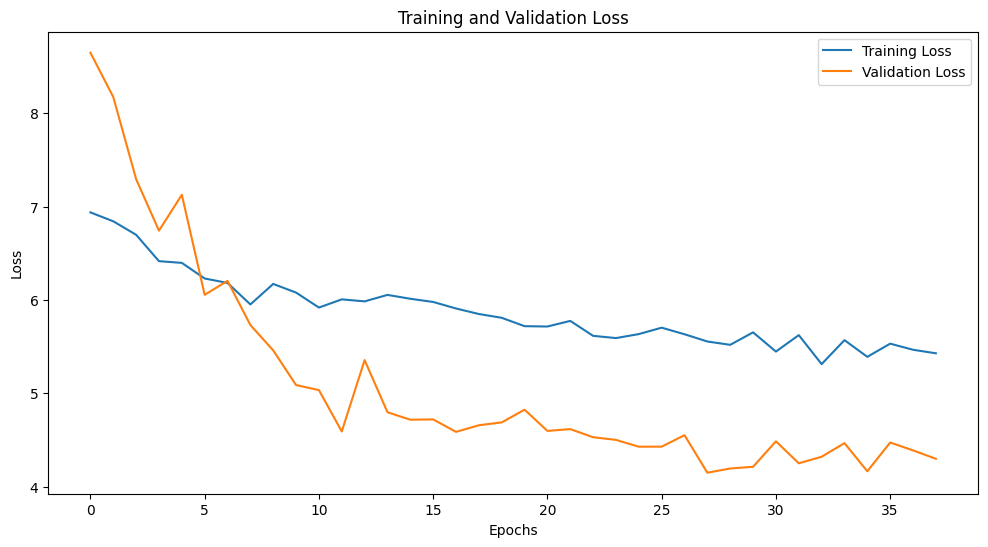

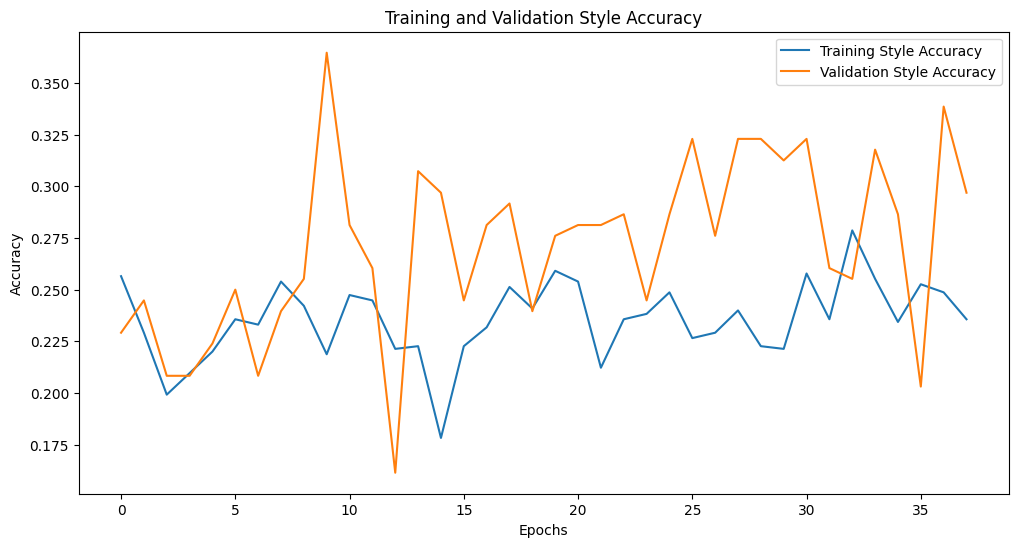

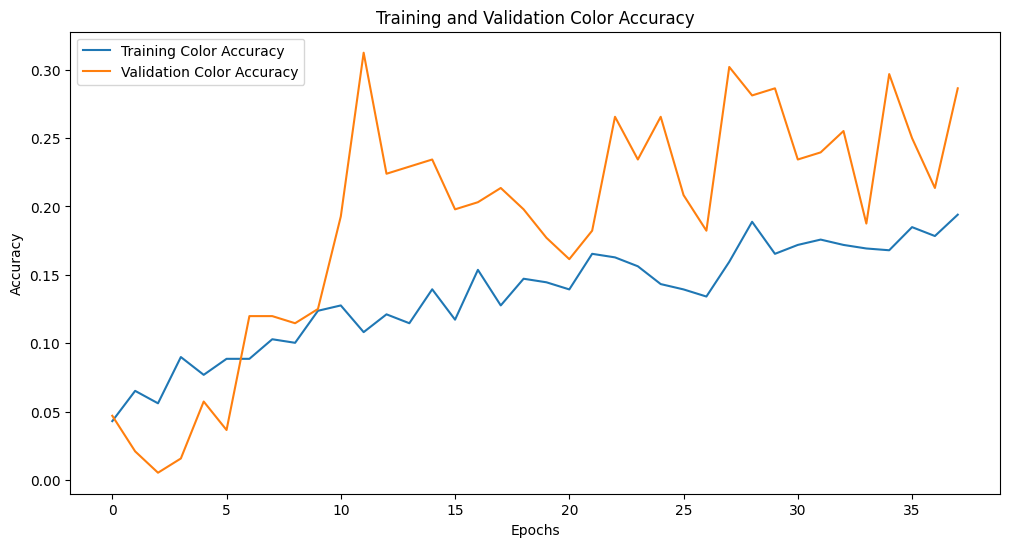

In [12]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)


### trial 2 : resNet 벡본, 출력 레이어에서 추가 head 생성

In [13]:
resnet_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
resnet_model.trainable = False

# resnet_model + add.layer
x = resnet_model.get_layer('conv5_block3_out').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(resnet_model.input,[style_prediction, color_prediction])
model.compile(optimizer='adam', loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_RESNET_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=1
)


history2=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback, early_stopping_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_RESNET_2.h5')

Epoch 1/100


<ipython-input-13-f31d242a3405>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2=model.fit_generator(training_set,


24/23 [==============================] - ETA: 0s - loss: 7.3397 - style_loss: 3.0262 - color_loss: 4.3135 - style_accuracy: 0.1406 - color_accuracy: 0.0651
Epoch 1: val_loss improved from inf to 21.02404, saving model to feature_extraction_RESNET_2.h5
23/23 [==============================] - 17s 408ms/step - loss: 7.3397 - style_loss: 3.0262 - color_loss: 4.3135 - style_accuracy: 0.1406 - color_accuracy: 0.0651 - val_loss: 21.0240 - val_style_loss: 11.3109 - val_color_loss: 9.7131 - val_style_accuracy: 0.2135 - val_color_accuracy: 0.0208
Epoch 2/100
24/23 [==============================] - ETA: 0s - loss: 6.7251 - style_loss: 2.7237 - color_loss: 4.0014 - style_accuracy: 0.1628 - color_accuracy: 0.0560
Epoch 2: val_loss improved from 21.02404 to 12.03547, saving model to feature_extraction_RESNET_2.h5
23/23 [==============================] - 7s 283ms/step - loss: 6.7251 - style_loss: 2.7237 - color_loss: 4.0014 - style_accuracy: 0.1628 - color_accuracy: 0.0560 - val_loss: 12.0355 - val

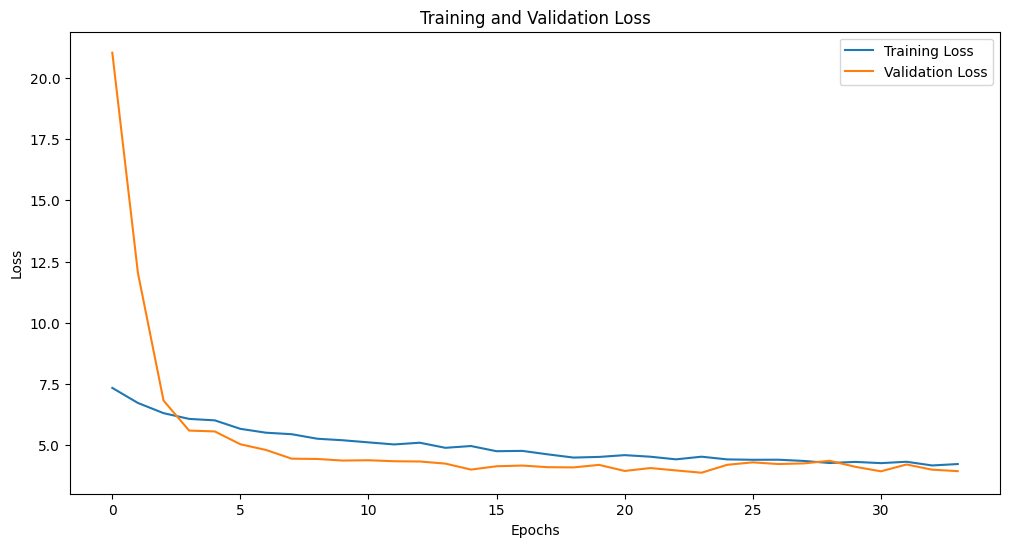

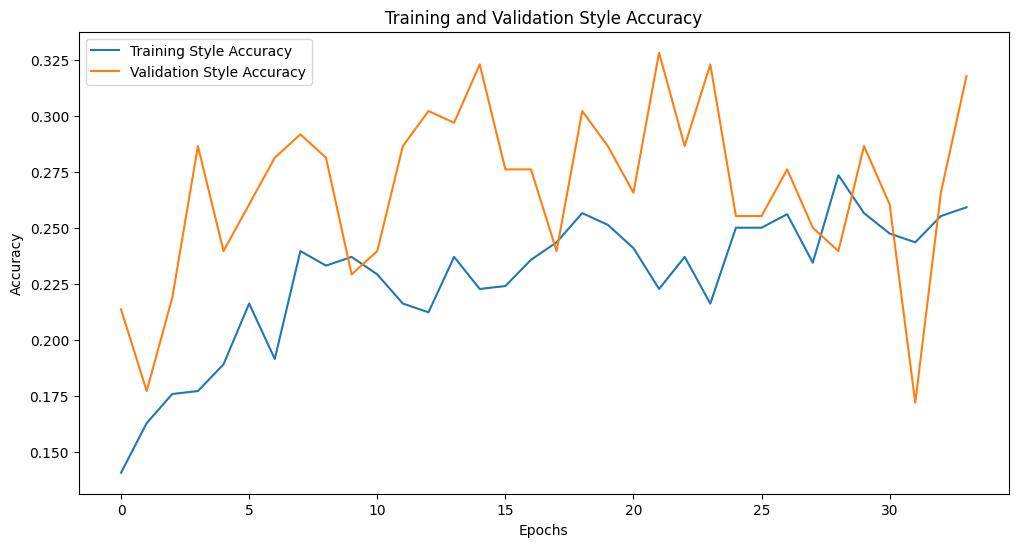

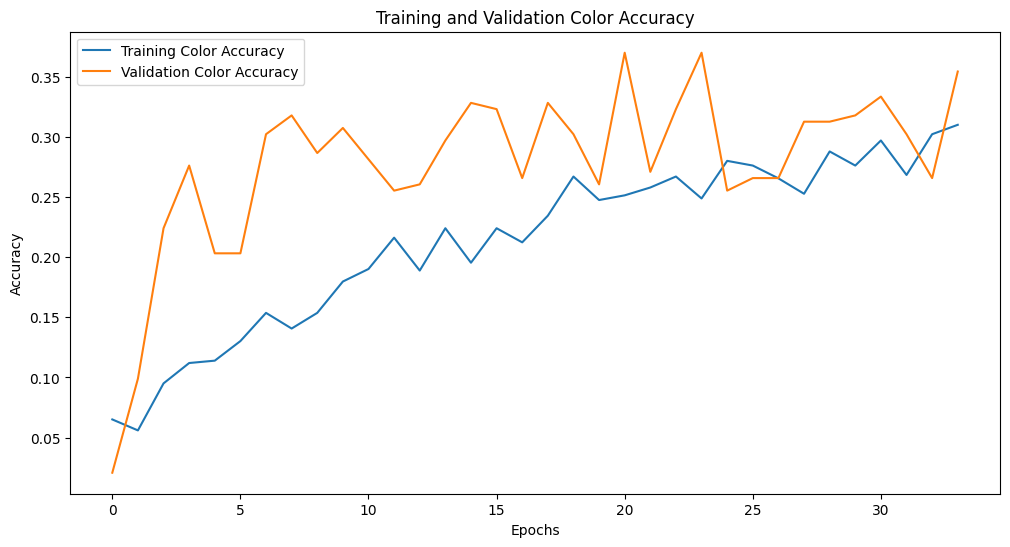

In [14]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history2)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history2)

# 색상 예측 정확도 시각화
plot_color_accuracy(history2)


### trial 3 : VGG 벡본, MLP부터 추가 head 생성

In [15]:
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
# vgg_model.summary()

# vgg_model + add.layer
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)


branch_b=layers.Dense(units=256)(x)
branch_b=layers.BatchNormalization()(branch_b)
branch_b=layers.Activation('relu')(branch_b)
branch_b=layers.Dropout(0.5)(branch_b)
branch_b=layers.Dense(units=128)(branch_b)
branch_b=layers.BatchNormalization()(branch_b)
branch_b=layers.Dropout(0.5)(branch_b)


style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_b)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer='adam', loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_vgg_1.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=1
)


history3=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback, early_stopping_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_vgg_1.h5')

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/100


<ipython-input-15-4ef60933572d>:49: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3=model.fit_generator(training_set,


24/23 [==============================] - ETA: 0s - loss: 7.1192 - style_loss: 2.9795 - color_loss: 4.1397 - style_accuracy: 0.1784 - color_accuracy: 0.0586
Epoch 1: val_loss improved from inf to 9.48287, saving model to feature_extraction_vgg_1.h5
23/23 [==============================] - 17s 275ms/step - loss: 7.1192 - style_loss: 2.9795 - color_loss: 4.1397 - style_accuracy: 0.1784 - color_accuracy: 0.0586 - val_loss: 9.4829 - val_style_loss: 4.6617 - val_color_loss: 4.8211 - val_style_accuracy: 0.2188 - val_color_accuracy: 0.0885
Epoch 2/100
24/23 [==============================] - ETA: 0s - loss: 6.3700 - style_loss: 2.5856 - color_loss: 3.7844 - style_accuracy: 0.1862 - color_accuracy: 0.1055
Epoch 2: val_loss improved from 9.48287 to 6.91654, saving model to feature_extraction_vgg_1.h5
23/23 [==============================] - 6s 244ms/step - loss: 6.3700 - style_loss: 2.5856 - color_loss: 3.7844 - style_accuracy: 0.1862 - color_accuracy: 0.1055 - val_loss: 6.9165 - val_style_loss:

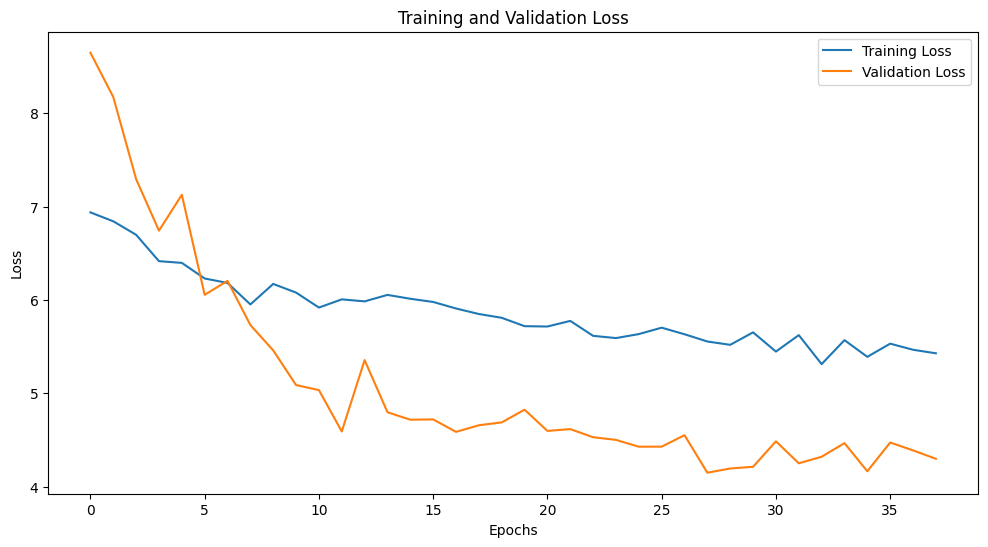

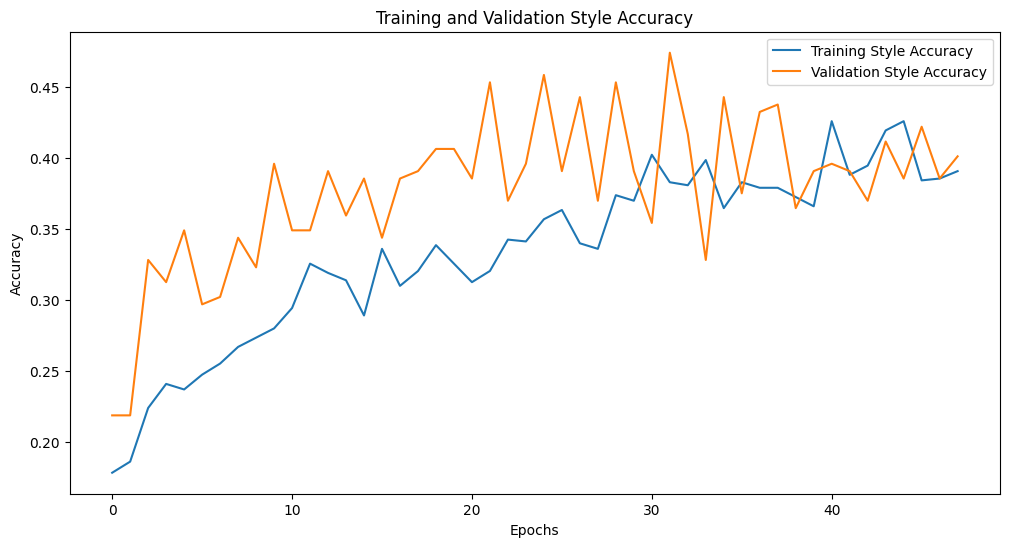

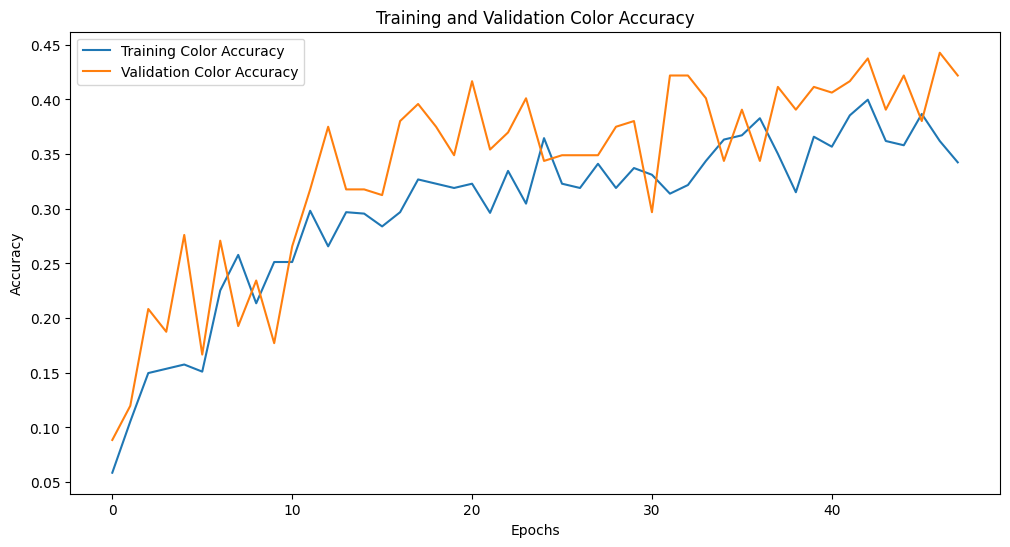

In [16]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history3)

# 색상 예측 정확도 시각화
plot_color_accuracy(history3)


### trial 4 : VGG 벡본, 출력 레이어에서 추가 head 생성

In [17]:
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
# vgg_model + add.layer
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer='adam', loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=1
)


history4=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback, early_stopping_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_VGG_2.h5')

Epoch 1/100


<ipython-input-17-a09b7b449576>:37: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4=model.fit_generator(training_set,


24/23 [==============================] - ETA: 0s - loss: 6.9407 - style_loss: 2.8846 - color_loss: 4.0561 - style_accuracy: 0.1589 - color_accuracy: 0.0638
Epoch 1: val_loss improved from inf to 7.90165, saving model to feature_extraction_VGG_2.h5
23/23 [==============================] - 9s 269ms/step - loss: 6.9407 - style_loss: 2.8846 - color_loss: 4.0561 - style_accuracy: 0.1589 - color_accuracy: 0.0638 - val_loss: 7.9017 - val_style_loss: 3.2590 - val_color_loss: 4.6427 - val_style_accuracy: 0.1823 - val_color_accuracy: 0.1042
Epoch 2/100
24/23 [==============================] - ETA: 0s - loss: 6.5630 - style_loss: 2.6976 - color_loss: 3.8654 - style_accuracy: 0.1823 - color_accuracy: 0.1016
Epoch 2: val_loss improved from 7.90165 to 6.24493, saving model to feature_extraction_VGG_2.h5
23/23 [==============================] - 5s 225ms/step - loss: 6.5630 - style_loss: 2.6976 - color_loss: 3.8654 - style_accuracy: 0.1823 - color_accuracy: 0.1016 - val_loss: 6.2449 - val_style_loss: 

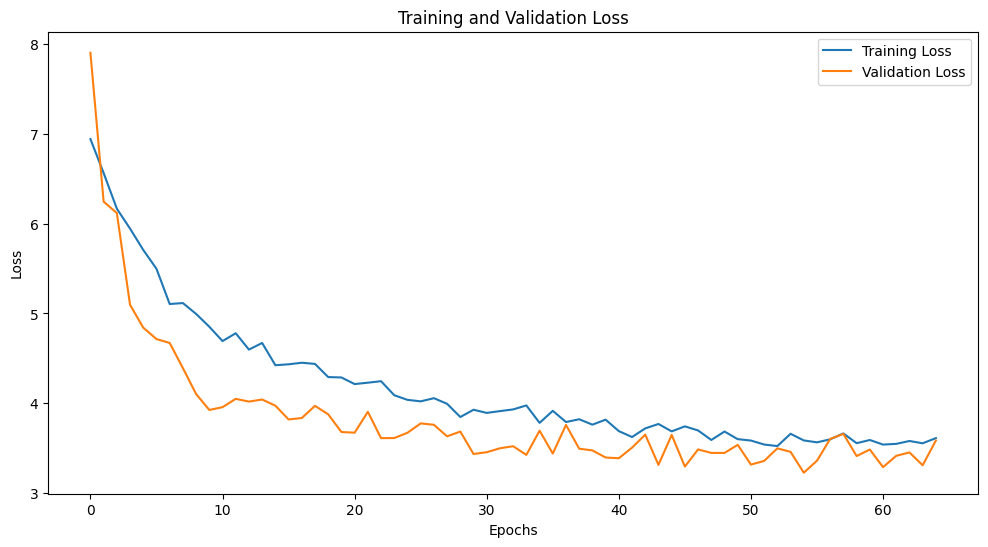

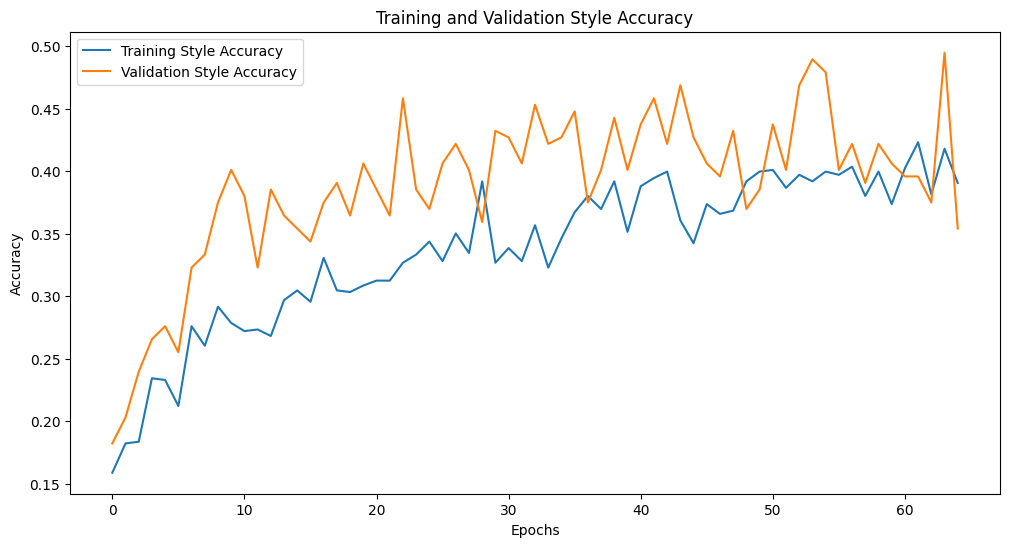

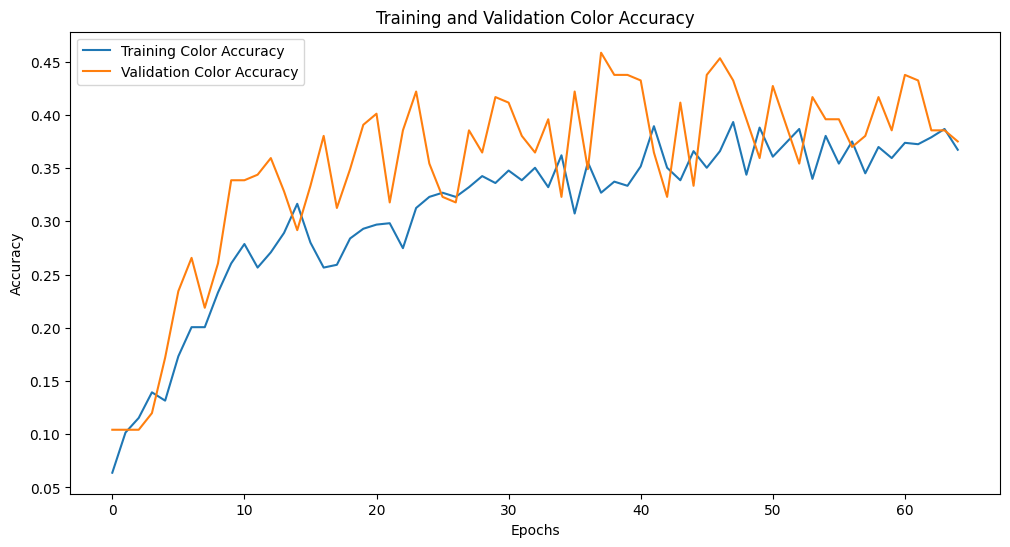

In [18]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history4)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history4)

# 색상 예측 정확도 시각화
plot_color_accuracy(history4)